In [1]:
import tensorflow as tf
from tensorflow import keras

from nn import datasets, models
from physics.hstar import gghzz, c6
from physics.hzz import zpair, angles
from physics.simulation import msq

import numpy as np
import matplotlib.pyplot as plt

import json, os

from sklearn.preprocessing import StandardScaler

2024-12-03 10:03:32.569863: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 10:03:32.620094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 10:03:32.620125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 10:03:32.620156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 10:03:32.631037: I tensorflow/core/platform/cpu_feature_g

In [2]:
SEED=373485

JOBS_DIR='jobs/'
CONFIG_FILE=JOBS_DIR + 'train-SIG-10x2000-100k/job.config'

In [3]:
config=None
scaler_config=None

with open(CONFIG_FILE, 'r') as config_file:
    config, scaler_config  = json.loads(''.join(config_file.readlines()))

print(config)

{'sample_dir': '../..', 'output_dir': 'train-SIG-10x2000-100k', 'flags': ['sig'], 'learning_rate': 1e-05, 'batch_size': 32, 'num_events': 100000, 'num_layers': 10, 'num_nodes': 2000.0, 'epochs': 100, 'c6_values': [-20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0, 12.0, 16.0, 20.0]}


In [4]:
sample = gghzz.Process(msq.Component.SIG, (1.4783394, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_sbi.csv'), 200000))
sample.events = sample.events[120000:]

In [5]:
'''sample = gghzz.Process(  
    (1.4783394, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_all_new.csv'), 500000)
    #(0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4e_all_new.csv'), 350000),
    #(0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4m_all_new.csv'), 350000)
)

sample.events = sample.events[333333:]'''

"sample = gghzz.Process(  \n    (1.4783394, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_all_new.csv'), 500000)\n    #(0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4e_all_new.csv'), 350000),\n    #(0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4m_all_new.csv'), 350000)\n)\n\nsample.events = sample.events[333333:]"

In [6]:
def get_components(config):
    component_flag = np.array(config['flags'])[np.where(np.array(config['flags']) in ['sig', 'int', 'sig-vs-sbi', 'int-vs-sbi', 'bkg-vs-sbi'])]
    component_flag = component_flag[0] if component_flag.shape[0] != 0 else 'sbi'
    component_1, component_2 = component_flag.split('-')[0], component_flag.split('-')[-1]
    
    comp_dict = {'sig': msq.Component.SIG,
                 'int': msq.Component.INT,
                 'bkg': msq.Component.BKG,
                 'sbi': msq.Component.SBI}

    return (comp_dict[component_1], comp_dict[component_2])

In [7]:
z_chooser = zpair.ZPairChooser(bounds1=(50,115), bounds2=(50,115), algorithm='leastsquare')

sample.events.filter(msq.MSQFilter('msq_bkg_sm', value=0.0))
sample.events.filter(msq.MSQFilter('msq_bkg_sm', value=np.nan))
#sample.events.filter(angles.M4lFilter(m4l_min=250,m4l_max=300))
l1_1, l2_1, l1_2, l2_2 = sample.events.filter(z_chooser)

kin_variables = angles.calculate(l1_1, l2_1, l1_2, l2_2)

true_size = kin_variables.shape[0]

print(kin_variables.shape)

print(config['c6_values'], len(config['c6_values']))

if len(config['c6_values']) == 1:
    c6_values = np.array(config['c6_values']) 
else:
    c6_values = np.linspace(config['c6_values'][0], config['c6_values'][-1], 41)

component_1, component_2 = get_components(config)

if component_1 != msq.Component.BKG:
    c6_mod = c6.Modifier(baseline = component_1, c6_values = [-5,-1,0,1,5])
    c6_weights, c6_prob = c6_mod.modify(sample=sample, c6=c6_values)
else:
    c6_weights, c6_prob = np.array(sample[component_1].weights)[:,np.newaxis], np.array(sample[component_1].probabilities)[:,np.newaxis]

(78607, 8)
[-20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0, 12.0, 16.0, 20.0] 11


In [8]:
data = []

signal_weights = c6_prob
background_weights = tf.convert_to_tensor(sample[component_2].probabilities)[:,tf.newaxis]

for i in range(len(c6_values)):
    param = c6_values[i]

    sig_weights = tf.cast(signal_weights.T[i][:,tf.newaxis], tf.float32)
    bkg_weights = tf.cast(background_weights, tf.float32)

    print(sig_weights)
    print(bkg_weights)

    if len(c6_values)==1:
        data.append(tf.concat([kin_variables, sig_weights, bkg_weights], axis=1))
    else:
        data.append(tf.concat([kin_variables, tf.ones(kin_variables.shape[0])[:,tf.newaxis]*param, sig_weights, bkg_weights], axis=1))

test_data = tf.reshape(tf.convert_to_tensor(data), (tf.convert_to_tensor(data).shape[0]*tf.convert_to_tensor(data).shape[1], tf.convert_to_tensor(data).shape[2]))

print(test_data)

2024-12-03 10:04:10.167282: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


tf.Tensor(
[[3.0807867e-05]
 [8.2398870e-08]
 [3.0423039e-06]
 ...
 [1.1402358e-05]
 [2.7145134e-06]
 [5.1805984e-07]], shape=(78607, 1), dtype=float32)
tf.Tensor(
[[1.3005930e-05]
 [6.1652349e-06]
 [9.4390452e-06]
 ...
 [9.3070557e-06]
 [1.0604036e-05]
 [5.6132644e-06]], shape=(78607, 1), dtype=float32)
tf.Tensor(
[[2.9146926e-05]
 [3.9037332e-08]
 [4.2623474e-06]
 ...
 [9.2286391e-06]
 [4.0205059e-06]
 [1.0247364e-06]], shape=(78607, 1), dtype=float32)
tf.Tensor(
[[1.3005930e-05]
 [6.1652349e-06]
 [9.4390452e-06]
 ...
 [9.3070557e-06]
 [1.0604036e-05]
 [5.6132644e-06]], shape=(78607, 1), dtype=float32)
tf.Tensor(
[[2.7074384e-05]
 [2.6759290e-07]
 [5.4927059e-06]
 ...
 [7.4385925e-06]
 [5.3826361e-06]
 [1.6416951e-06]], shape=(78607, 1), dtype=float32)
tf.Tensor(
[[1.3005930e-05]
 [6.1652349e-06]
 [9.4390452e-06]
 ...
 [9.3070557e-06]
 [1.0604036e-05]
 [5.6132644e-06]], shape=(78607, 1), dtype=float32)
tf.Tensor(
[[2.4833484e-05]
 [7.1583128e-07]
 [6.6154626e-06]
 ...
 [6.1589039e-06

In [9]:
scaler = StandardScaler()

print(test_data, test_data.shape)

scaler.mean_ = scaler_config['scaler.mean_']
scaler.var_ = scaler_config['scaler.var_']
scaler.scale_ = scaler_config['scaler.scale_']

test_data = tf.concat([scaler.transform(test_data[:,:-2]), test_data[:,-2:]], axis=1)

print(test_data, test_data.shape)

mu = tf.reduce_sum(test_data[:,:-2], axis=0)/test_data.shape[0]

print('Mean (after):', mu)

sigma = tf.math.reduce_std(test_data[:,:-2], axis=0)

print('sigma (after):', sigma)

tf.Tensor(
[[-9.8596752e-01  9.8954272e-01  9.9558413e-01 ... -2.0000000e+01
   3.0807867e-05  1.3005930e-05]
 [-8.8101757e-01  7.5902045e-01 -3.3603385e-01 ... -2.0000000e+01
   8.2398870e-08  6.1652349e-06]
 [ 9.9992752e-01  9.9543577e-01  9.9921322e-01 ... -2.0000000e+01
   3.0423039e-06  9.4390452e-06]
 ...
 [ 9.9231058e-01  9.9717212e-01 -4.6564189e-01 ...  2.0000000e+01
   7.4347176e-06  9.3070557e-06]
 [-9.9181402e-01  9.7647601e-01  9.9856353e-01 ...  2.0000000e+01
   5.8370606e-06  1.0604036e-05]
 [-7.2120029e-01 -6.0986483e-01  9.1251755e-01 ...  2.0000000e+01
   1.8861316e-06  5.6132644e-06]], shape=(3222887, 11), dtype=float32) (3222887, 11)
tf.Tensor(
[[-1.2568347e+00  5.4243612e-01  5.5756259e-01 ... -1.5811388e+00
   3.0807867e-05  1.3005930e-05]
 [-1.1241683e+00  1.1098679e-01 -1.9178987e+00 ... -1.5811388e+00
   8.2398870e-08  6.1652349e-06]
 [ 1.2535207e+00  5.5346566e-01  5.6430906e-01 ... -1.5811388e+00
   3.0423039e-06  9.4390452e-06]
 ...
 [ 1.2438922e+00  5.56715

In [10]:
model = keras.models.load_model(os.path.join(JOBS_DIR, config['output_dir'], 'checkpoint.model.tf'), custom_objects={'C6_4l_clf': models.C6_4l_clf, 'swish_activation': models.swish_activation})

In [11]:
data = test_data[:,:8][:,np.newaxis]

print(data)
predictions = model.predict(data, verbose=1)

real_ratios = test_data[:,8]/test_data[:,9]

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

real = real_ratios.numpy()
pred = ratios.numpy()

tf.Tensor(
[[[-1.2568347e+00  5.4243612e-01  5.5756259e-01 ...  6.0834455e-01
    2.6700952e+00 -9.1966677e-01]]

 [[-1.1241683e+00  1.1098679e-01 -1.9178987e+00 ... -2.6604903e-01
   -6.7620409e-01 -1.3042196e+00]]

 [[ 1.2535207e+00  5.5346566e-01  5.6430906e-01 ...  4.0465387e-05
    3.0162787e-01 -1.6691430e+00]]

 ...

 [[ 1.2438922e+00  5.5671543e-01 -2.1588383e+00 ... -8.6649649e-02
    2.1855856e-01 -1.1784527e+00]]

 [[-1.2642252e+00  5.1798028e-01  5.6310129e-01 ... -4.5272997e-01
    5.2716291e-01 -1.5943286e+00]]

 [[-9.2214441e-01 -2.4510417e+00  4.0314287e-01 ...  7.9339194e-01
   -9.9513423e-01 -1.4273561e+00]]], shape=(3222887, 1, 8), dtype=float32)


ValueError: in user code:

    File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filekjju4mkw.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).custom_layers[0], (ag__.ld(inputs),), None, fscope)

    ValueError: Exception encountered when calling layer 'c6_4l_clf' (type C6_4l_clf).
    
    in user code:
    
        File "/raven/u/griesemx/ggZZ_work/higgs-offshell-interpretation/nn/models.py", line 46, in call  *
            x = self.custom_layers[0](inputs)
        File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 1, 8)
    
    
    Call arguments received by layer 'c6_4l_clf' (type C6_4l_clf):
      • inputs=tf.Tensor(shape=(None, 1, 8), dtype=float32)


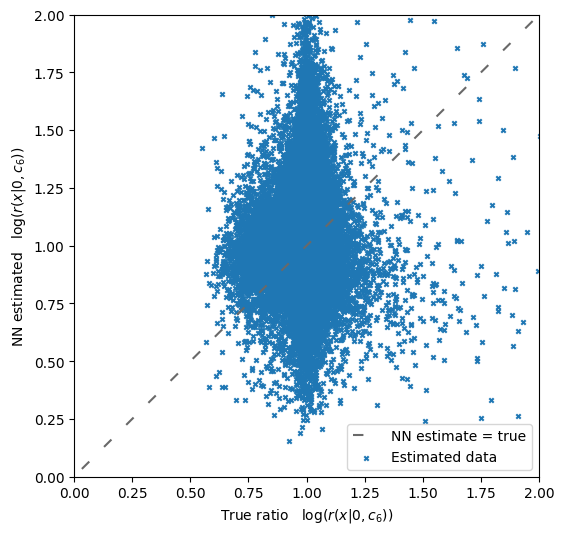

In [ ]:
lnspc = np.linspace(-3.0,2.5)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label=f'Estimated data')
plt.xlabel(u'True ratio   log$(r(x|0,c_6))$')#$P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   log$(r(x|0,c_6))$')#$P(x|c_6)/P_0(x)$')
plt.xlim(0.0,2.0)
plt.ylim(0.0,2.0)
plt.legend()

plt.show()

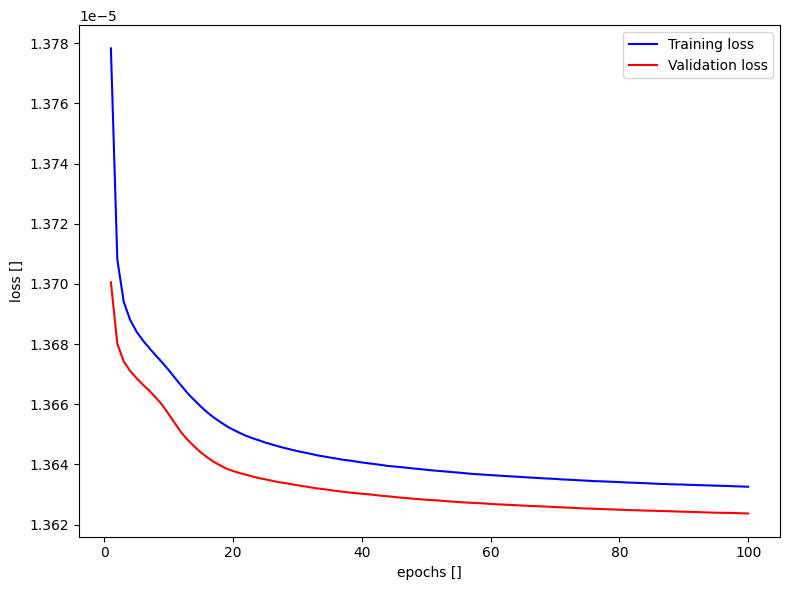

In [12]:
hist_prm = ''

with open(os.path.join(JOBS_DIR, config['output_dir'], 'history.txt'), 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,t_loss_prm.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()

In [13]:
rndint = np.random.choice(np.arange(0,true_size)).astype(int)

print(rndint)

data = test_data[rndint::true_size,:9][:,np.newaxis]

print(data.shape)

pred = model.predict(data, verbose=2)

real_ratios = test_data[rndint::true_size,9]/test_data[rndint::true_size,10]

pred = tf.convert_to_tensor(pred)

ratios = tf.squeeze(pred/(1-pred), axis=2)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

max_val = max(tf.math.reduce_max(real_ratios).numpy(), tf.math.reduce_max(ratios).numpy())

real = real_ratios.numpy()
pred = ratios.numpy()

print(real.shape)
print(pred.shape)

49946
(41, 1, 9)
2/2 - 1s - 1s/epoch - 606ms/step
tf.Tensor(
[[0.23990646]
 [0.162781  ]
 [0.12271074]
 [0.11105201]
 [0.12000449]
 [0.14642827]
 [0.18930048]
 [0.24718362]
 [0.3171719 ]
 [0.39517763]
 [0.47678843]
 [0.5580118 ]
 [0.635652  ]
 [0.7073988 ]
 [0.7717516 ]
 [0.8278738 ]
 [0.87542427]
 [0.9143897 ]
 [0.94493556]
 [0.96729064]
 [0.9816612 ]
 [0.98817885]
 [0.9868735 ]
 [0.9776663 ]
 [0.960382  ]
 [0.93477213]
 [0.9005591 ]
 [0.857501  ]
 [0.80549407]
 [0.74472225]
 [0.67585677]
 [0.60028476]
 [0.52029544]
 [0.43911663]
 [0.36068672]
 [0.28910637]
 [0.22787474]
 [0.17919005]
 [0.1436811 ]
 [0.12075154]
 [0.10938399]], shape=(41, 1), dtype=float32) tf.Tensor(0.10938399, shape=(), dtype=float32) tf.Tensor(0.98817885, shape=(), dtype=float32)
tf.Tensor(
[0.5158184  0.28207925 0.12361225 0.04667471 0.04176561 0.09043705
 0.1727764  0.2720603  0.37627703 0.4777522  0.5720862  0.6570792
 0.7318902  0.7964561  0.8511187  0.896397   0.9328546  0.96102506
 0.98137236 0.99427134 1.   

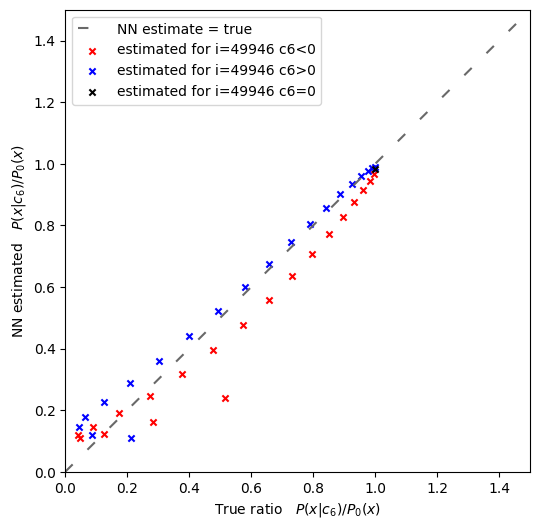

In [14]:
lnspc = np.linspace(0.0,max_val + 0.5)

plt.figure(figsize=(6,6))

c6_0 = int((len(c6_values)-1)/2)

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real[:c6_0], pred[:c6_0], color='r', s=20, marker='x', label=f'estimated for i={rndint} c6<0')
plt.scatter(real[c6_0+1:], pred[c6_0+1:], color='b', s=20, marker='x', label=f'estimated for i={rndint} c6>0')
plt.scatter(real[c6_0], pred[c6_0], color='k', s=20, marker='x', label=f'estimated for i={rndint} c6=0')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.0,max_val + 0.5)
plt.ylim(0.0,max_val + 0.5)
plt.legend()
#19
plt.show()

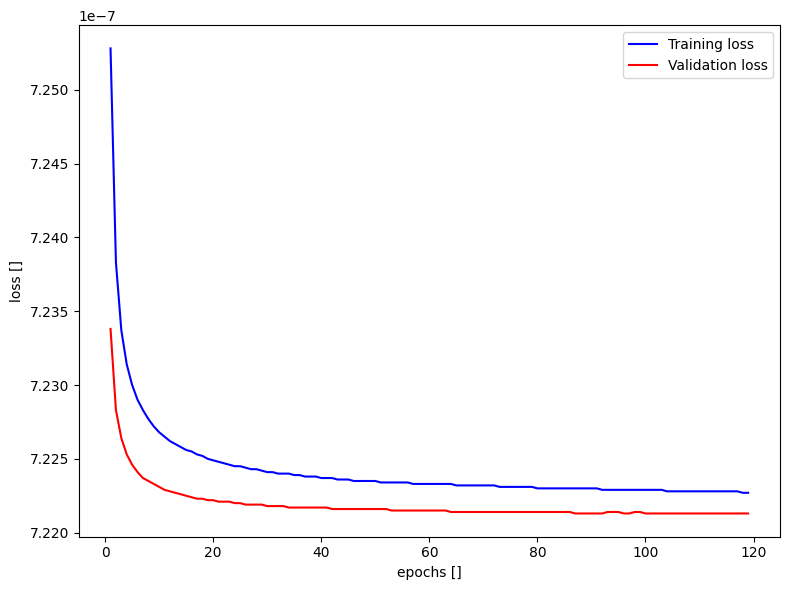

In [ ]:
JOB_ID = 13876921
JOB_OUT_FILE = os.path.join(JOBS_DIR, config['output_dir'], 'logs', 'job.out.' + str(JOB_ID))

import re

with open(JOB_OUT_FILE, 'r') as log_file:
    logs = ''.join(log_file.readlines())

t_loss = np.array(re.findall("\ loss:\ ([0-9]\.[0-9]+e?-?[0-9]*)\ -", logs)).astype(np.float32)
v_loss = np.array(re.findall("\ val_loss:\ ([0-9]\.[0-9]+e?-?[0-9]*)\ -", logs)).astype(np.float32)

epochs = range(1,t_loss.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss []')
#ax2.legend()

plt.plot(epochs, v_loss, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()

In [ ]:
data = test_data[:,:-2]

c6_val = 20
c6_scaled = (c6_val-scaler.mean_[8])/scaler.scale_[8]

data = tf.gather(data,tf.where(data[:,-1]==c6_scaled))
data = tf.reshape(data, shape=(data.shape[0], data.shape[1]*data.shape[2]))

print(data)
predictions = model.predict(data, verbose=1)

test_data_at_c6 = tf.gather(test_data,tf.where(test_data[:,-3]==c6_scaled))
test_data_at_c6 = tf.reshape(test_data_at_c6, shape=(test_data_at_c6.shape[0], test_data_at_c6.shape[1]*test_data_at_c6.shape[2]))
print(test_data_at_c6)

real_ratios = test_data_at_c6[:,-2]/test_data_at_c6[:,-1]

predictions = tf.convert_to_tensor(predictions)

ratios = predictions/(1-predictions)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

real = real_ratios.numpy()
pred = ratios.numpy()

tf.Tensor(
[[-1.2568347   0.5424361   0.5575626  ...  2.6700952  -0.91966677
   0.7905694 ]
 [-1.1241683   0.11098679 -1.9178987  ... -0.6762041  -1.3042196
   0.7905694 ]
 [ 1.2535207   0.55346566  0.56430906 ...  0.30162787 -1.669143
   0.7905694 ]
 ...
 [ 1.2438922   0.5567154  -2.1588383  ...  0.21855856 -1.1784527
   0.7905694 ]
 [-1.2642252   0.5179803   0.5631013  ...  0.5271629  -1.5943286
   0.7905694 ]
 [-0.9221444  -2.4510417   0.40314287 ... -0.99513423 -1.4273561
   0.7905694 ]], shape=(78607, 9), dtype=float32)
2457/2457 [==============================] - 519s 211ms/step
tf.Tensor(
[[-1.25683475e+00  5.42436123e-01  5.57562590e-01 ...  7.90569425e-01
   1.42955569e-05  1.30059298e-05]
 [-1.12416828e+00  1.10986792e-01 -1.91789865e+00 ...  7.90569425e-01
   5.38163567e-06  6.16523494e-06]
 [ 1.25352073e+00  5.53465664e-01  5.64309061e-01 ...  7.90569425e-01
   9.57669909e-06  9.43904524e-06]
 ...
 [ 1.24389219e+00  5.56715429e-01 -2.15883827e+00 ...  7.90569425e-01
   7.92

[autoreload of nn.datasets failed: Traceback (most recent call last):
  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/u/griesemx/ggZZ_work/venv_tf/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2023.03/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/raven/u/griesemx/ggZZ_work/higgs-offshell-interpretation/nn/datasets.py", line 89
 

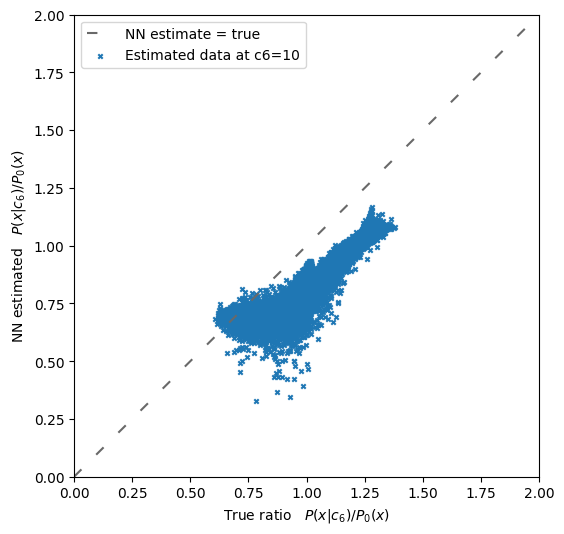

In [31]:
lnspc = np.linspace(0.0,2.0)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label=f'Estimated data at c6={c6_val}')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.0,2.0)
plt.ylim(0.0,2.0)
plt.legend()

plt.show()